In [1]:
import mmh3
import numpy as np
import pandas as pd
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
N = 1000000
max_priority = 7
mea_T = 0
color_table = ['red', 'green', 'blue', 'c', 'pink', 'purple', 'orange', 'crimson', 'skyblue', 'chocolate', 'violet', 'navy']
color_lst = [color_table[i] for i in range(max_priority)]
high_prior_flows = set([6,7])
mediumn_prior_flows = set([])
low_prior_flows = set([1,2,3,4,5])
import math
class NDS:
    '''
        -prob: 无重采样的概率
        -m: 无重采样片上bloom filter的大小
        -N: 总共的无重元素数目,需要通过FM sketch或者预先设置一个大值处理
    '''
    def __init__(self, prob, m):
        self.prob = prob
        self.pre_rate = prob
        self.m = m
        self.c = 0                        #  记录B中1比特的数目
        self.k = 1 #math.ceil(np.log(2) * (m / N)) # 最优哈希函数数目
        self.B = np.zeros(shape = (self.m,), dtype = np.int32)
        self.hash_seeds = [ np.random.randint(i * 10000, (i + 1) * 10000) for i in range(self.k)]
        self.sample_seed = 34324
        self.hash_table = {}
        self.hash_collsions = {}
        self.downloads = 0
        for i in range(1, max_priority + 1):
            self.hash_table[i] = defaultdict(int)
            self.hash_collsions[i] = defaultdict(set)
        print("空间占用:{}KB.".format(m / 8 / 1024))
    
    def update(self, src, dst, p):
        # 原文中无论如何都会进入第二阶段, 因此第一阶段的预采样就是判断是否加入到片下哈希表
        # 所以先对bloom filter进行置位操作
        flag = False # 假设该元素是重复元素
        for i in range(self.k):
            idx = mmh3.hash(src + dst, seed = self.hash_seeds[i]) % self.m
            self.hash_collsions[p][src + "+" + dst].add(idx) # 测试哈希冲突
            if self.B[idx] == 0:
                self.B[idx] = 1
                self.c += 1
                flag = True # 该元素为非重复元素
        if flag == True:
            if mmh3.hash(src + dst, seed = self.sample_seed) % 0xffffffff <= self.pre_rate * 0xffffffff:
                self.hash_table[p][src] += 1
                self.downloads += 1
                self.pre_rate = self.prob / (1 - (self.c / self.m) ** self.k)
    
    def estimate(self, src):
        for i in range(1, max_priority + 1):
            if src in self.hash_table[i]:
                return int(self.hash_table[i][src] / self.prob)
        else:
            return 0

In [3]:
filename = "./CAIDA 2016/00_7.txt"
f = open(filename, 'r')
datas = f.readlines()
test_keys = set([])
real_set_spread = {}
real_spread = {}
for i in range(1, max_priority + 1):
    real_spread[i] = defaultdict(int)
    real_set_spread[i] = defaultdict(set)
N = len(datas)
nds = NDS(0.109, 50 * 1024 * 8)
for row in tqdm(datas):
    src, dst, p = row.split()
    p = int(p)
    nds.update(src, dst, p)
    real_set_spread[p][src].add(dst)
print("nds总共下载{}个元素.".format(nds.downloads))
for i in range(1, max_priority + 1):
    for key in real_set_spread[i]:
        if len(real_set_spread[i][key]) >= mea_T:
            real_spread[i][key] = len(real_set_spread[i][key])
            test_keys.add(key)
f.close()
print(nds.c / nds.m)

  2%|▏         | 16911/907463 [00:00<00:10, 86220.33it/s] 

空间占用:50.0KB.


100%|██████████| 907463/907463 [00:08<00:00, 105935.22it/s]


nds总共下载99119个元素.
0.89114013671875


100%|██████████| 907463/907463 [00:01<00:00, 463135.26it/s]
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/tmp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10


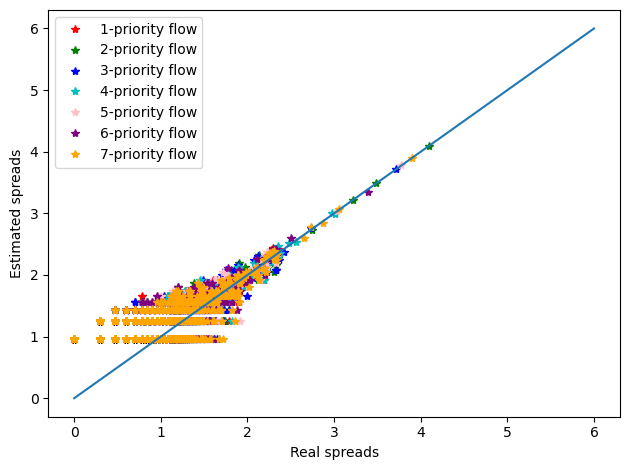

In [4]:
are = 0
flow_count = 0
estimate_spread = {}
are_dict = {}
class_are_dict = {'low':0, 'high':0, 'med':0}
flow_count_dict = {}
fine_are_dict = {}
flow_count_p = {'low':0, 'high':0, 'med':0}
for i in range(1, max_priority + 1):
    flow_count_dict[i] = 0
    fine_are_dict[i] = {}
    for j in range(0, 7, 1):
        fine_are_dict[i][j] = 0
for i in range(1, max_priority + 1):
    are_dict[i] = 0
    estimate_spread[i] = defaultdict(int)
for row in tqdm(datas):
    src, dst, p = row.split()
    p = int(p)
    temp_v = nds.estimate(src)
    if src in test_keys:
        estimate_spread[p][src] = temp_v
for i in range(1, max_priority + 1):
    x_log, y_log = [], []
    temp_range_count = defaultdict(int)
    for src in real_spread[i]:
        temp_v = abs(real_spread[i][src] - estimate_spread[i][src]) / real_spread[i][src]
        are += temp_v
        flow_count += 1
        are_dict[i] += temp_v
        flow_count_dict[i] += 1
        temp_range_count[int(round(math.log10(real_spread[i][src])))] += 1
        fine_are_dict[i][int(round(math.log10(real_spread[i][src])))] += temp_v
        if i in high_prior_flows:
            class_are_dict['high'] += temp_v
            flow_count_p['high'] += 1
        elif i in mediumn_prior_flows:
            class_are_dict['med'] += temp_v
            flow_count_p['med'] += 1
        elif i in  low_prior_flows:
            class_are_dict['low'] += temp_v
            flow_count_p['low'] += 1
        x_log.append(real_spread[i][src])
        y_log.append(estimate_spread[i][src])
    for j in range(0, 7):
        if temp_range_count[j] == 0:
            fine_are_dict[i][j] = 0
        else:
            fine_are_dict[i][j] = fine_are_dict[i][j] / temp_range_count[j]
    x_log = np.log10(x_log)
    y_log = np.log10(y_log)
    plt.plot(x_log, y_log, '*', color = color_lst[i - 1], label = str(i) + "-priority flow")
class_are_dict['low'] = class_are_dict['low'] / flow_count_p['low'] if flow_count_p['low'] != 0 else None
class_are_dict['med'] = class_are_dict['med'] / flow_count_p['med'] if flow_count_p['med'] != 0 else None
class_are_dict['high'] = class_are_dict['high'] / flow_count_p['high'] if flow_count_p['high'] != 0 else None
for i in range(1, max_priority + 1):
    are_dict[i] = are_dict[i] / flow_count_dict[i] if flow_count_dict[i] != 0 else None
x = np.arange(math.log10(mea_T) if mea_T != 0 else 0, 7, 1)
plt.plot(x, x)
plt.legend()
plt.xlabel("Real spreads")
plt.ylabel("Estimated spreads")
#plt.title("Non-duplicate sampling")
plt.tight_layout()
plt.savefig("NDS_100KB.jpg")
plt.show()

In [5]:
for i in range(1, max_priority + 1):
    print("[Message] 第{}优先级流的are信息如下:".format(i))
    for j in range(0, 7, 1):
        if fine_are_dict[i][j] != 0:
            print("  第{}个区间内的are为{}".format(j, fine_are_dict[i][j]))
print(are_dict)
print(class_are_dict)
print(are / flow_count)

[Message] 第1优先级流的are信息如下:
  第0个区间内的are为1.7347648132989106
  第1个区间内的are为0.985553746118975
  第2个区间内的are为0.28094346198332476
[Message] 第2优先级流的are信息如下:
  第0个区间内的are为1.7333270357075383
  第1个区间内的are为0.9909893455618831
  第2个区间内的are为0.3061349793081912
  第3个区间内的are为0.01978173330490984
  第4个区间内的are为0.006467582242095178
[Message] 第3优先级流的are信息如下:
  第0个区间内的are为1.7555969682567476
  第1个区间内的are为0.9862919356958868
  第2个区间内的are为0.31767400079645436
  第3个区间内的are为0.09514925373134328
  第4个区间内的are为0.0030668966839179604
[Message] 第4优先级流的are信息如下:
  第0个区间内的are为1.7342703560098696
  第1个区间内的are为0.9781012884904967
  第2个区间内的are为0.26870220687299484
  第3个区间内的are为0.057841363407179415
[Message] 第5优先级流的are信息如下:
  第0个区间内的are为1.7305130997534017
  第1个区间内的are为0.9900692318248265
  第2个区间内的are为0.3001928713710735
  第3个区间内的are为0.010968921389396709
  第4个区间内的are为0.00887177770338132
[Message] 第6优先级流的are信息如下:
  第0个区间内的are为1.7435873466945857
  第1个区间内的are为0.9805013798310135
  第2个区间内的are为0.31782911634413896
  第3个区间内的are为0.16067072786207

In [6]:
cluster_inner = {}
cluster_outer = {}
idx_pkt_table = {}
for i in range(1, max_priority + 1):
    cluster_inner[i] = 0
    cluster_outer[i] = 0
    idx_pkt_table[i] = defaultdict(set)

for i in range(1, max_priority + 1):
    for pkt in nds.hash_collsions[i]:
        idx_lst_ = sorted(nds.hash_collsions[i][pkt])
        idx_lst_str = [str(ele) for ele in idx_lst_]
        temp_key = "+".join(idx_lst_str)
        idx_pkt_table[i][temp_key].add(pkt)

# 计算类内哈希冲突
for i in range(1, max_priority + 1):
    for key in idx_pkt_table[i]:
        cluster_inner[i] += len(idx_pkt_table[i][key]) - 1

# 计算类间哈希冲突
for i in range(1, max_priority + 1):
    i_keys = set(idx_pkt_table[i].keys())
    for j in range(i + 1, max_priority + 1):
        j_keys = set(idx_pkt_table[j].keys())
        intersection_keys = i_keys.intersection(j_keys)
        for key in intersection_keys:
            cluster_outer[i] += len(idx_pkt_table[j][key])
            cluster_outer[j] += len(idx_pkt_table[i][key])

print("类内哈希冲突:")
print(cluster_inner)
print("类间哈希冲突:")
print(cluster_outer)

类内哈希冲突:
{1: 15961, 2: 20461, 3: 17927, 4: 16918, 5: 18043, 6: 16598, 7: 24266}
类间哈希冲突:
{1: 199916, 2: 218783, 3: 208777, 4: 204860, 5: 208364, 6: 204023, 7: 232100}
